In [4]:
import pandas as pd
import matplotlib.pyplot as plt

#import pyodbc
#import numpy as np
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [9]:
def main():    
    df = pd.read_csv('input/2023Jan1-2023Nov30AmznSalesReportR.csv')

    df['product sales']=df['product sales'].apply(lambda x: x.replace(',',''))
    df['product sales'] = df['product sales'].astype(float)

    df['other']=df['other'].apply(lambda x: x.replace(',',''))
    df['other'] = df['other'].astype(float)

    df['total']=df['total'].apply(lambda x: x.replace(',',''))
    df['total'] = df['total'].astype(float)

    Oid = df.loc[~df['order id'].isnull()]

    #fba
    ifba = Oid.loc[Oid['fulfillment']=='Amazon']
    #get number of fba orders
    fba_count = ifba['order id'].nunique()

    ifba['sku']=ifba['sku'].apply(lambda x: str(x)[:9])
    with_costs_fba = getCosts(ifba)
    sums_fba = getSums(with_costs_fba, 'Amazon', df)
    
    sums_fba['Totals']= sums_fba['Totals'].apply(lambda x: round(x,2))
    
    sums_fba.loc['Number of Orders'] = [fba_count,'']
    

    #fbm
    ifbm = Oid.loc[Oid['fulfillment']=='Seller']
    #get number of fbm orders
    fbm_count = ifbm['order id'].nunique()
    
    with_costs_fbm = getCosts(ifbm)
    sums_fbm = getSums(with_costs_fbm, 'Seller', df)
    
    sums_fbm['Totals']= sums_fbm['Totals'].apply(lambda x: round(x,2))
    
    sums_fbm.loc['Number of Orders'] = [fbm_count,'']
    
    
    #service fees
    sf = getServiceFees(df)
    
    return sums_fba, sums_fbm, sf
    
    
if __name__ == '__main__':
    fba, fbm, sf = main()

In [14]:
sf

,Totals
Additional Costs,
Cost of Advertising,-32833.25
Subscription,-192.53


In [16]:
fba

,Totals,percent of sales
product sales,757939.16,100.0
shipping credits,7639.29,1.0
promotional rebates,-5330.06,0.7
selling fees,-112330.86,14.8
fba fees,-105663.46,13.9
cost of goods,429947.94,56.7
adjustments total,4656.05,0.6
FBA Inventory Reimbursement - General Adjustment,-992.24,0.1
FBA Inventory Reimbursement - Customer Return,2618.72,0.3
FBA Inventory Reimbursement - Customer Service Issue,219.56,0.0


In [18]:
len(fbm)

14

In [5]:
def getServiceFees(df):
    
    sf_df = df.loc[df['type']=='Service Fee']
    sf = sf_df.groupby('description')['total'].sum().reset_index()
    sf = pd.DataFrame(sf)
    sf = sf.rename(columns={'description':'Additional Costs','total':'Totals'}).set_index('Additional Costs')

    
    return sf

In [6]:
def getCostsFromFile(file, merchant_df):
    '''
    Format of cost file
    
             sku | cost
       ----------|-----
       073134801 | 30.32

       
    '''
    cost_gb = pd.DataFrame(file.groupby('sku')['cost'].mean().reset_index(),columns=['sku','cost'])
    
    both = merchant_df.join(cost_gb.set_index('sku'), on='sku')
    #add extended cost (cost * quantity)
    both['cost of goods'] = both['quantity'] * both['Unit Cost']
    #Drop all refunds
    bothNoRefunds = both.loc[both['type']=='Order']
    
    return bothNoRefunds

In [7]:
def getCosts(merchant_df):    
    #order costs
    ordCost = pd.read_excel('input/amznCostOrders.xlsx')
    ordCost.rename(columns={'Product Number':'sku'}, inplace=True)
    cost = ordCost[['sku', 'Unit Cost']]
    #drop returned (RM) orders
    cost = cost.loc[cost['Unit Cost']>0]
    #get the average cost for each sku (regardless of whse)
    cost_gb = pd.DataFrame(cost.groupby('sku')['Unit Cost'].mean().reset_index(),columns=['sku','Unit Cost'])
    #format skus (leading zeros) for fba orders
    cost_gb['sku'] = cost_gb['sku'].astype(str)
    cost_gb['sku'] = cost_gb['sku'].str.zfill(9)
    #add cost to orders df
    both = merchant_df.join(cost_gb.set_index('sku'), on='sku')
    #add extended cost (cost * quantity)
    both['cost of goods'] = both['quantity'] * both['Unit Cost']
    #Drop all refunds
    bothNoRefunds = both.loc[both['type']=='Order']
    
    return bothNoRefunds

In [8]:
def getSums(fulfill_df, fulfillment, df):
    refunds = df.loc[(df['fulfillment']==fulfillment) & (df['type']=='Refund')]

    include = ['product sales', 'shipping credits', 'promotional rebates', 'selling fees',
           'fba fees', 'total' ,'cost of goods']
    sums = fulfill_df[include].sum()
    sums = pd.DataFrame(sums, columns=['Totals'])
    #add fulfillment specific fees
    if fulfillment == 'Amazon':

        sums.loc['adjustments total'] = df.loc[df['type']=='Adjustment'][include[:6]].sum()['total']
        #add fba external fees
        for i in df.loc[df['type']=='Adjustment']['description'].unique():
            val = round(df.loc[(df['type']=='Adjustment') & (df['description']==i)]['total'].sum(),2)
            sums.loc[i]= val

        sums.loc['fba inventory fees total'] = df.loc[df['type']=='FBA Inventory Fee'][include[:6]].sum()['total']
        #add fba external fees
        for i in df.loc[df['type']=='FBA Inventory Fee']['description'].unique():
            val = round(df.loc[(df['type']=='FBA Inventory Fee') & (df['description']==i)]['total'].sum(),2)
            sums.loc[i]= val

        sums.loc['refunds'] = refunds['total'].sum()

    elif fulfillment == 'Seller':
        sums.loc['fbm shipping services total'] = df.loc[df['type']=='Shipping Services'][include[:6]].sum()['total']
        #add fbm external fees
        for i in df.loc[df['type']=='Shipping Services']['description'].unique():
            val = round(df.loc[(df['type']=='Shipping Services') & (df['description']==i)]['total'].sum(),2)
            sums.loc[i]= val

        sums.loc['refunds'] = refunds['total'].sum()

    net = sums.loc['total']['Totals'] - sums.loc['cost of goods']['Totals']
    if fulfillment == 'Amazon':
        net_less_fees = net + sums.loc['adjustments total']['Totals'] + sums.loc['fba inventory fees total']['Totals'] + sums.loc['refunds']['Totals']
    else:
        net_less_fees = net +  sums.loc['fbm shipping services total']['Totals'] + sums.loc['refunds']['Totals']

    sums.loc['net profit'] = net_less_fees
    
    #include_percent = ['product sales','shipping credits','promotional rebates', 'selling fees', 'fba fees',' adjustments total',\
    #'fba inventory fees total','fbm shipping services total', 'refunds']

    #sums['percent of sales'] = sums.apply(lambda x: round(abs(((x['Totals'] / sums.loc['product sales']) * 100)),1) if x.index in include_percent else None)
    sums['percent of sales'] = sums['Totals'].apply(lambda x: round(abs(((x / sums.loc['product sales']) * 100)),1))
    
    sums.drop(index='total',inplace=True)

    return sums

In [97]:
def aovGraph(Oid):    
    #graph all orders
    ords = Oid.loc[Oid['type']=='Order']
    #remove fba suffix 
    ords['sku']=ords['sku'].apply(lambda x: str(x)[:9])
    #get costs
    ordCost = pd.read_excel('input/amznCostOrders.xlsx')
    #format
    ordCost.rename(columns={'Product Number':'sku'}, inplace=True)
    cost = ordCost[['sku', 'Unit Cost']]
    #drop returned (RM) orders
    cost = cost.loc[cost['Unit Cost']>0]
    #get avercost of each sku
    cost_gb = pd.DataFrame(cost.groupby('sku')['Unit Cost'].mean().reset_index(),columns=['sku','Unit Cost'])
    #leading zeros
    cost_gb['sku'] = cost_gb['sku'].astype(str)
    cost_gb['sku'] = cost_gb['sku'].str.zfill(9)
    #add costs to orders df
    graph = ords.join(cost_gb.set_index('sku'), on='sku')
    #get extended cost
    graph['Extended Cost'] = graph['quantity'] * graph['Unit Cost']
    #subset
    subset = graph[['order id', 'product sales', 'total','Extended Cost']]
    #get totals by order
    aoc = pd.DataFrame(subset.groupby('order id').sum().reset_index())
    #get net profit column
    aoc['net profit'] = aoc['total'] - aoc['Extended Cost']
    #sort
    aoc.sort_values(by='product sales',inplace=True)
    #remove orders with 0 sales price
    aoc.drop(aoc[aoc['product sales']==0].index, inplace = True)
    #filter orders to be within 3 standard deviations
    aocZ = aoc[(np.abs(aoc['product sales']-aoc['product sales'].mean())<=(3 * aoc['product sales'].std())) & (np.abs(aoc['net profit']-aoc['net profit'].mean())<=(3 * aoc['net profit'].std()))]

    #plot
    sns.set_theme(style="darkgrid")
    #rename aocZ columns so labels make sense
    aocZ.rename(columns={'product sales': 'Order Value ($)', 'net profit': 'Order Net Profit ($)'},inplace=True)

    slope, intercept, r_value, pv, se = stats.linregress(aocZ['Order Value'], aocZ['Order Net Profit'])

    aov_mean = aocZ['Order Value'].mean()

    #AOV
    ov_x = aov_mean
    ov_y = slope * ov_x + intercept

    #AOV increased by 10%
    ov2_x = aov_mean + (aov_mean * .1)
    ov2_y = slope * ov2_x + intercept

    range_y = aocZ['Order Net Profit'].min() * .8
    range_x = 0

    x = sns.regplot(x='Order Value ($)', y='Order Net Profit ($)', data=aocZ, 
      ci=None, scatter_kws={'alpha': 0.1}, line_kws={'color':'red'}, label=f'y={round(slope,2)}x+{round(intercept,2)}').legend(loc="best")
    #Order value
    plt.plot([ov_x,ov_x], [ov_y, range_y], linewidth=1,color='black')
    #net profit
    plt.plot([range_x,ov_x], [ov_y,ov_y], linewidth=1,color='black')

    #AOV increased by 10% 
    plt.plot([ov2_x,ov2_x], [ov2_y, range_y], linewidth=1,color='black')
    plt.plot([range_x,ov2_x], [ov2_y,ov2_y], linewidth=1,color='black')

    #limit as percent
    plt.xlim(0,(aocZ['Order Value ($)'].max() - aocZ['Order Value ($)'].mean()) * .65)
    plt.ylim(0,(aocZ['Order Net Profit ($)'].max() - aocZ['Order Net Profit ($)'].mean()) * .65)
    #plt.savefig('lmplotreg.png') 
    plt.plot()

    increase = (((aocZ.shape[0] * ov2_y) - (aocZ.shape[0] * ov_y)) / (aocZ.shape[0] * ov_y)) * 100
    description = f'In terms of standardized orders (within 3 std\'s), \
    the current AOV of ${round(ov_x,2)} gives us an average net profit of ${round(ov_y,2)}. \
    If we increase the AOV by 10% (${round(aov_mean*.1,2)}) to ${round(ov2_x,2)}, we increase our average net profit to ${round(ov2_y,2)}, \
    which increases our annual net profit by {round(increase,1)}%.'
    
    return description,x

("In terms of standardized orders (within 3 std's),     the current AOV of $53.78 gives us an average net profit of $11.06.     If we increase the AOV by 10% ($5.38) to $59.16, we increase our average net profit to $11.96,     which increases our annual net profit by 8.2%.",
 <matplotlib.legend.Legend at 0x1cc7578ce90>)

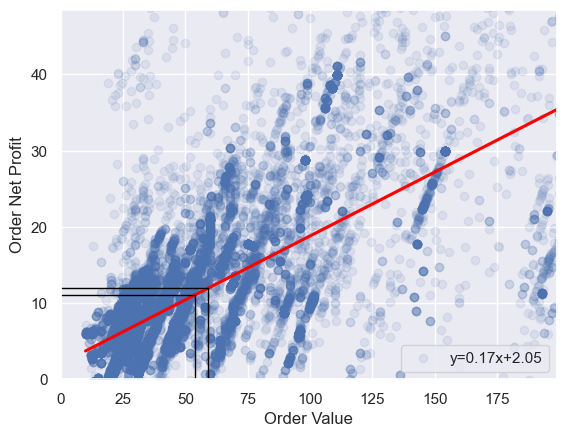

In [98]:
aovGraph(Oid)

In [16]:
import xlsxwriter

workbook = xlsxwriter.Workbook("test1.xlsx")
worksheet = workbook.add_worksheet("sheet1R")
worksheet.add_table('B3:F7', {'data': fbm.values.T.tolist(),'style': 'Table Style Light 17'})

workbook.close()

ModuleNotFoundError: No module named 'xlsxwriter'

In [3]:
print('l')

l


In [2]:
!conda install conda-forge::xlsxwriter

^C
